In [1]:
%matplotlib inline
import numpy as np
from pathlib import Path
from ipitools import utils_free_energy_tutorial as utils
from ipitools.io import read_ipi_output, read_ipi_xyz
from ipi.utils.units import unit_to_user, unit_to_internal, Constants
from scipy.integrate import quad
try:
    from numpy import trapezoid
except ImportError:
    from numpy import trapz as trapezoid
except:
    raise

<p/>
<p style="font-size:48px; font-weight: bolder; text-align: center"> Free Energy Calulations with i-PI </p>
<p style="font-size:18px; text-align: center"><i> authored by:  Hannah Bertschi, Jorge Castro, George Trenins </i></p>
<p style="font-size:18px; text-align: center"><i> adapted from <a href="https://github.com/i-pi/piqm2023-tutorial" target="_blank">tutorials for the PIQM-2023 Advanced School</a></i></p>

# Introduction

In this tutorial, you will learn how to perform free-energy calculations using the [i-PI](https://ipi-code.org/) software package. We will compare classical and path-integral molecular dynamics (MD) simulations, and see how to account for anharmonicity and nuclear quantum effects in free energy. 
This notebook serves as lecture notes and a quick-start guide. We will perform some classical thermodynamic integration simulations and post-process the output from PIMD. 
For more information on the [input](https://docs.ipi-code.org/input-tags.html) and [output](https://docs.ipi-code.org/output-tags.html) tags, we refer the reader to the corresponding sections of the [i-PI manual](https://docs.ipi-code.org/index.html). 

---


# Theoretical background 

## Free Energy Differences 

Free energy differences determine equilibrium properties, such as the relative stabilities of different conformers, coordination complexes, and phases. Consider two thermodynamic states, A and B, each described by their own Hamiltonian, $H_A(\mathbf{p}, \mathbf{q})$ and $H_B(\mathbf{p}, \mathbf{q})$, where $\mathbf{q}$ and $\mathbf{p}$ denote the system’s coordinates and momenta, respectively. The free energy difference between these two states is defined as

$$
\Delta F_{AB} = F_B - F_A = -k_B T \ln \left( \frac{Z_B}{Z_A} \right)
$$

where the partition function for state $X$ is:

$$
Z_X = \int \mathrm{d}\mathbf{p} \, \mathrm{d}\mathbf{q} \; e^{-H_X(\mathbf{p}, \mathbf{q}) / k_B T}
$$

In general, this is a high-dimensional integral that is best calculated numerically using importance sampling, e.g., Molecular Dynamics (MD) or Monte Carlo (MC).

---

## Thermodynamic Integration

A robust approach to computing free-energy differences is thermodynamic integration. In this approach, we consider a continuous transformation between states A and B parametrized by $\lambda \in [0, 1]$. We define a family of interpolated Hamiltonians,

$$
H_\lambda(\mathbf{p}, \mathbf{q}) \quad \text{such that} \quad
\begin{cases}
H_0 = H_A \\
H_1 = H_B
\end{cases}
$$

The dependence of the Hamiltonian on the coupling parameter $\lambda$ is problem-specific. In general, $\lambda$ may influence both the kinetic and potential energy terms — for instance, by scaling particle masses or introducing alchemical changes. Here, we consider systems that only differ in their **potential energy** and choose a linear interpolation as our transformation:


$$
H_\lambda(\mathbf{p}, \mathbf{q}) = (1 - \lambda ) H_A(\mathbf{p}, \mathbf{q}) + \lambda H_B(\mathbf{p}, \mathbf{q}) = \sum_{\alpha}\frac{\lvert\mathbf{p}_{\alpha} \rvert^2}{2 m_{\alpha}} + (1 - \lambda ) U_A( \mathbf{q}) + \lambda U_B( \mathbf{q}) 
$$

Given the free energy $F_{\lambda}$ corresponding to the Hamiltonian $H_{\lambda}$, we may write

$$
\Delta F_{AB} = F_{1} - F_{0} = \int_0^1 \frac{\mathrm{d} F}{\mathrm{d} \lambda} \, \mathrm{d} \lambda
$$

The derivative of the free energy with respect to the parameter $\lambda$ takes the form of a thermal average:

$$
\begin{align*}
    \frac{\mathrm{d} F}{\mathrm{d} \lambda} & = \frac{\mathrm{d} }{\mathrm{d} \lambda} \Big( - k_B T \ln Z_{\lambda} \Big) = 
    - k_B T \frac{1}{ Z_{\lambda}} \frac{\mathrm{d} Z_{\lambda} }{\mathrm{d} \lambda} \\
   \rule[-0.5em]{0pt}{2.5em}%
   & =  - k_B T \frac{1}{ Z_{\lambda}} \left( \int \mathrm{d}\mathbf{p} \, \mathrm{d}\mathbf{q} \; \left[ - \frac{U_B - U_A}{k_B T} \right] e^{-H_{\lambda}(\mathbf{p}, \mathbf{q}) / k_B T} \right) \\
   \rule[-0.5em]{0pt}{2.5em}%
   & = \left\langle U_B - U_A \right\rangle_{\lambda},
\end{align*}
$$

which we can obtain directly from an MD simulation. Finally, the free energy difference is computed from

$$
\Delta F_{AB} = \int_{0}^{1} \left\langle U_B(\mathbf{q}) - U_A(\mathbf{q}) \right\rangle_{\lambda} \mathrm{d}\lambda 
$$

by numerical quadrature over $\lambda$ using, e.g., the trapezoidal rule. In practice, this amount to the following steps:

1. **Discretize the $\lambda$-interval** into a set of points $\{\lambda_k\}$ (e.g., 0.0, 0.1, ..., 1.0).  
2. **Run MD or MC simulations** at each $\lambda_k$ to estimate the ensemble average $\left\langle U_B - U_A \right\rangle_{\lambda_k}$.  
3. **Numerically integrate** these averages using a quadrature method such as the trapezoidal rule or Simpson’s rule to obtain $\Delta F_{AB}$.


For a detailed discussion, see Chapter 8 of D. M. Tuckerman’s *Statistical Mechanics: Theory and Molecular Simulation*.

# Free-energy calculation

The figure below outlines two alternatives to computing anharmonic vibrational free energies using thermodynamic integration (TI).

In the first approach, we compute the *classical harmonic* free energy, which can be done analytically given the harmonic frequencies of the system. We then compute the classical *anharmonic correction* using classical TI. Finally, we "upgrade" the free energy to include the "quantum correction", which can be done using PIMD and a "mass" TI algorithm described later in the tutorial.

In the second approach, we directly compute the *quantum harmonic* free energy, which can also be done analytically. The quantum anharmonic corrections are added using PIMD TI. 

<figure style="text-align: center;">
    <img src="figures/TOC_free_energy.png" alt="Free-energy increments from equilibrium to anharmonic quantum" style="width:400px;">
    <figcaption style="font-style: italic; font-size: 90%;">Two thermodynamic integration strategies for computing anharmonic vibrational free energies.</figcaption>
</figure>

## Model potential

Our simple model represents a hydrogen atom adsorbed on a surface. The potential energy is comprised of two components

- A Morse potential along the z direction, to model the anharmonic bond with the surface
- A harmonic potential in the lateral (x and y) directions, to model the preference for a particular adsorption site.

$$
U(\mathbf{q}) =
D_e \left(1 - \mathrm{e}^{-\alpha\,(z - z_0)} \right)^2
+ \dfrac{1}{2}k(x^2 + y^2)
$$

|           Mass            |    Dissociation energy     |    Bond length   |         Bond stiffness            |
| :-----------------------: | :------------------------: | :--------------: | :-------------------------------: |
| _m_ = 1837.4 _m_<sub>e</sub> | _D_<sub>e</sub> = 200 meV | _z_<sub>0</sub> = 1.11 Å | _α_ = 0.75 Å<sub>0</sub><sup>–1</sup> |


The dissociation energy and bond stiffness along the _z_-direction imply a harmonic frequency

  $$
  \omega_e = \alpha\sqrt{\frac{2D_e}{m}} \approx 263\;\mathrm{cm}^{-1}.
  $$
The harmonic spring constant _k_ is chosen to match the frequency $ \omega \approx 520\,\mathrm{cm}^{-1} $.



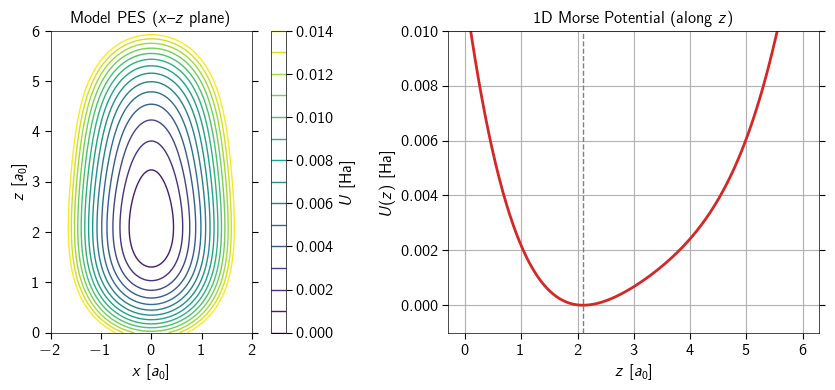

In [2]:
# Let's take a look at the Morse potential
# Parameters
De    = 0.2      # eV
a    = 0.75    # angstrom^(-1)
z0   = 1.11    # angstrom
k    = 1.0     # eV / angstrom^2

# Call the plotting function
fig = utils.plot_pes_morse(D=De, a=a, z0=z0, k=k);

## Harmonic approximation

The Taylor series expansion of the potential energy surface around the equilibrium geometry reads
$$
U(\mathbf{q}_0 + \delta \mathbf{q}) \sim U(\mathbf{q}_0) + \frac{1}{2} (\delta \mathbf{q}_0)^{\top} \mathbf{H} \mkern2mu (\delta \mathbf{q}_0),
$$
where $\mathbf{H}$ is the Hessian matrix evaluated at equilibrium,
$$
H_{ij} = \left. \frac{\partial^2 U}{\partial q_i \partial q_j} \right\rvert_{\mathbf{q} = \mathbf{q}_0}.
$$
The harmonic frequencies can be extracted from this matrix. For our model system, the Hessian is diagonal, and the harmonic frequencies are known analytically:
$$
\omega_{x,y} = \sqrt{\frac{k}{m}}, \qquad \omega_z =  \alpha \sqrt{\frac{2\,D_e}{m}}\ .
$$
In general, such frequencies are computed from the **dynamical matrix** $\mathbf{K}$, which is simply the mass-weighted Hessian:
$$
\mathbf{K}_{\alpha,\beta} = \frac{1}{\sqrt{m_{\alpha} m_{\beta}} } \mathbf{H}_{\alpha,\beta},
$$
with $[\cdot]_{\alpha,\beta}$ denoting the 3 $\times$ 3 matrix block coupling atoms with the indices $\alpha$ and $\beta$ and masses $m_{\alpha}$ and $m_{\beta}$. The frequencies are obtained by solving the eigenproblem for this dynamical matrix,
$$
\mathbf{K}_{\alpha,\beta} \mathbf{v}_{n} = \omega_n^2  \mathbf{v}_{n}.
$$



### Classical harmonic vibrational free energy

For a system with vibrational frequencies $ \{ \omega_n \} $, the classical harmonic free energy is:

$$
F_{\text{ch}} = \frac{1}{\beta} \sum_n \ln\left( \beta \hbar \omega_n \right)
$$

### Quantum harmonic vibrational free energy

The quantum harmonic free energy includes both zero-point energy and thermal contributions:

$$
F_{\text{qh}} = \sum_n \left[ \frac{\hbar \omega_n}{2} + \frac{1}{\beta} \ln\left( 1 - e^{-\beta \hbar \omega_n} \right) \right]
$$

Here, $ \beta = 1 / (k_B T) $, $ \hbar $ is the reduced Planck constant. All free energies are given relative to the equilibrium potential.


### Geometry optimization

#### Input files

To compute the harmonic frequencies numerically, we must first locate the equilibrium geometry $ q_0 $. The corresponding i-PI input files have been set up in the `geometry_optimization` directory

```bash
cd geometry_optimization
```
Open the `input.xml` file and locate the following section:

```xml
<motion mode='minimize'>
  <optimizer mode='bfgs'>
    <tolerances>
      <energy> 1e-5 </energy>
      <force> 1e-5 </force>
      <position> 1e-5 </position>
    </tolerances>
  </optimizer>
</motion>
```

At every step of the "dynamics" we move towards a local minimum of the PES. Here, the moves are determined by the BFGS algorithm, but other [options](https://docs.ipi-code.org/input-tags.html#id121) are available. The tolerances set thershold values for changes in the energy, positions and forces, that are sufficient to deem an optimization converged. 

#### Running the calculation

To perform geometry optimization using i-PI, navigate to the `geometry_optimization` directory and run

```bash
./run_geometry_opt.sh
```

This script launches i-PI in the background, where it awaits communication from the driver that supplies the energies and forces:

```bash
# Start i-PI in the background and redirect output to a log file
i-pi input.xml &> log.i-pi &
# Give i-PI a moment to start up
sleep 2
# Launch the driver with appropriate options
i-pi-py_driver -u -a geop -m MorseHarmonic -o 0.2,0.75,1.11,1.0 &> log.driver &

```

The values passed to the driver via the `-o` flag correspond to the parameters of our model potential: $D_e$, $\alpha$, $z_0$, and $k$, respectively.

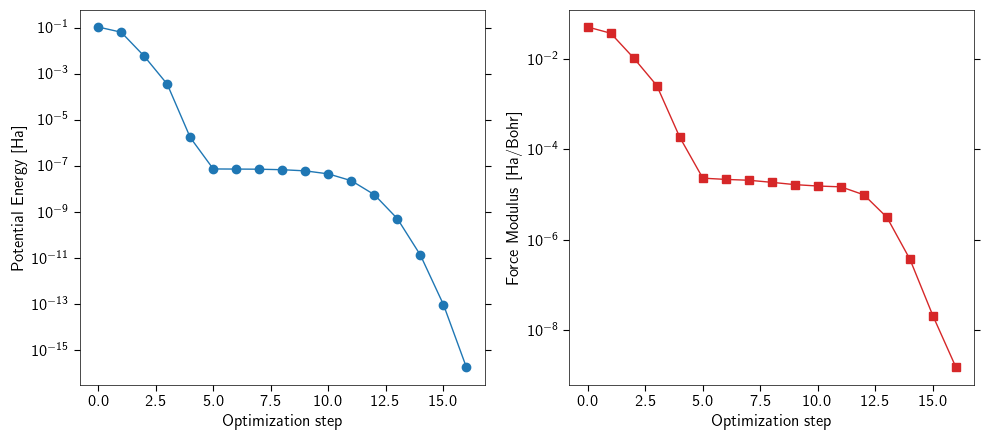

In [3]:
# Is your geometry optimization converged?
basepath = Path('.')   # Change to Path('outputs') to load precomputed results
filepath = basepath.joinpath('geometry_optimization', 'simulation.out')
utils.plot_geometry_opt(filepath)

### Hessian Matrix Computation

To compute the system's **Hessian matrix**, change to the appropriate directory:

```bash
cd harmonic_approximation
```

Then open the `input.xml` file and locate the following section:

```xml
<motion mode='vibrations'>
  <vibrations mode='fd'>
    <pos_shift> 0.001 </pos_shift>
    <prefix> phonons </prefix>
  </vibrations>
</motion>
```

Here, we use the `vibrations` mode of [i-PI](https://docs.ipi-code.org/input-tags.html#vibrations), which calculates the second derivatives of the potential energy via central finite differences of atomic forces.

To initialize the calculation, create a symbolic link to the optimized geometry from the previous step:

```bash
ln -s ../geometry_optimization/RESTART geop-RESTART
```

This file provides the starting configuration. Now launch the calculation with `./run_hessian.sh`. After completion, the Hessian matrix is saved to `simulation.phonons.hess`; the sqaured normal-mode frequencies are saved to `simulation.phonons.eigval`.

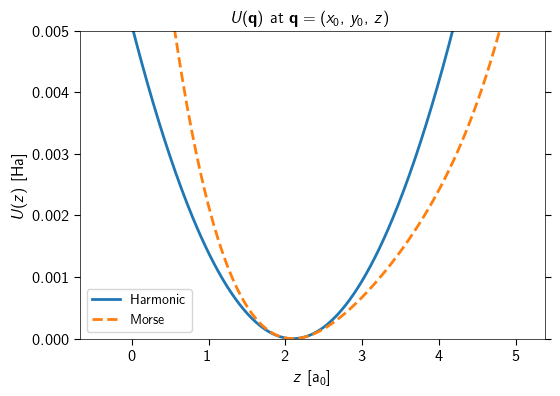

In [4]:
# How do the Morse PES and the harmonic approximation compare?
rootdir = Path(".").joinpath("harmonic_approximation") # Change to Path('outputs') to load precomputed results
hess = np.loadtxt(rootdir.joinpath("simulation.phonons.hess"))
q0 = unit_to_internal("length", "angstrom",  np.array([0,0,z0]))  # Convert to atomic units
V0 = np.loadtxt(rootdir.joinpath("simulation.out"), usecols=1).item()
utils.compare_pes_1d_z(hess, q0, V0, D=De, a=a, k=k, span_z=(-2.5, 3.0))

### Harmonic free energies

In [5]:
# print the harmonic frequencies
rootdir = Path(".").joinpath("harmonic_approximation") # Change to Path('outputs') to load precomputed results
# The eigval file contains the eigenvalues of the Hessian matrix, i.e., the squares of the frequencies
W2s = np.sort(np.loadtxt(rootdir.joinpath('simulation.phonons.eigval')))[::-1] # sort in decreasing order
Ws = np.sqrt(W2s)
print ('###  Harmonic Frequencies: ###\n')
# The frequencies are in atomic units, we convert to cm^-1
for l,w in zip('xyz', Ws):
    print(f"ω({l}) = {unit_to_user('frequency', 'inversecm', w):7.2f} cm^-1")

###  Harmonic Frequencies: ###

ω(x) =  519.41 cm^-1
ω(y) =  519.41 cm^-1
ω(z) =  246.38 cm^-1


These frequencies can be used to calculate the classical and quantum harmonic free energy of the system. From here onwards we will **only** report the free energies for the **z-coordinate**, which is decoupled from the other two trivially harmonic directions.

In [6]:
def betaTemp(T):
    """
    Convert from temperature in Kelvin to 1/(kB*T) in atomic units
    """
    T = unit_to_internal("temperature", "kelvin", T)
    beta = 1 / (Constants.kb * T)
    return beta

In [7]:
def classical_harmonic_free_energy(Ws, T):
    """
    Receives a list of frequencies in atomic units and the temperature in Kelvin. 
    Returns the system's classical harmonic free energy.
    """
    beta = betaTemp(T)
    ans = np.log(beta * Constants.hbar * np.asarray(Ws)).sum()
    return ans / beta

In [8]:
def quantum_harmonic_free_energy(Ws, T):
    """
    Receives a list of frequencies in atomic units and the temperature in Kelvin. 
    Returns the system's quantum harmonic free energy.
    """
    beta = betaTemp(T)
    Ws = np.asarray(Ws)
    # zero-point energies
    zpe = Constants.hbar * Ws / 2
    # thermal excitations
    therm = np.log(1 - np.exp(-beta*Constants.hbar*Ws)) / beta
    return (zpe + therm).sum()

In [9]:
# Lets compute the quantum and classical harmonic free energies using the functions defined above
T = 300 # Kelvin
print("Classical harmonic free energy:")
F_ch = classical_harmonic_free_energy(Ws[-1], T)
utils.print_energy(F_ch)
print("Quantum harmonic free energy:")
F_qh = quantum_harmonic_free_energy(Ws[-1], T)
utils.print_energy(F_qh)

Classical harmonic free energy:
   0.159 [mHa]
   4.31 [meV]
   0.416 [kJ/mol]

Quantum harmonic free energy:
   0.213 [mHa]
   5.80 [meV]
   0.560 [kJ/mol]



### Breakdown of the harmonic approximation

- **Left: Low temperature (50 K)**  
  Both the Morse and harmonic distributions are tightly peaked around the equilibrium $z_0\approx2.2$ a.u. The two nearly coincide, as expected for a harmonic approximation when the system only explores a small range of displacements from equilibrium.

- **Right: High temperature (300 K)**  
  The exact Morse distribution develops an asymmetric tail toward larger $z$ as the increased amplitude of thermal fluctuations allows the system to explore more of the PES.

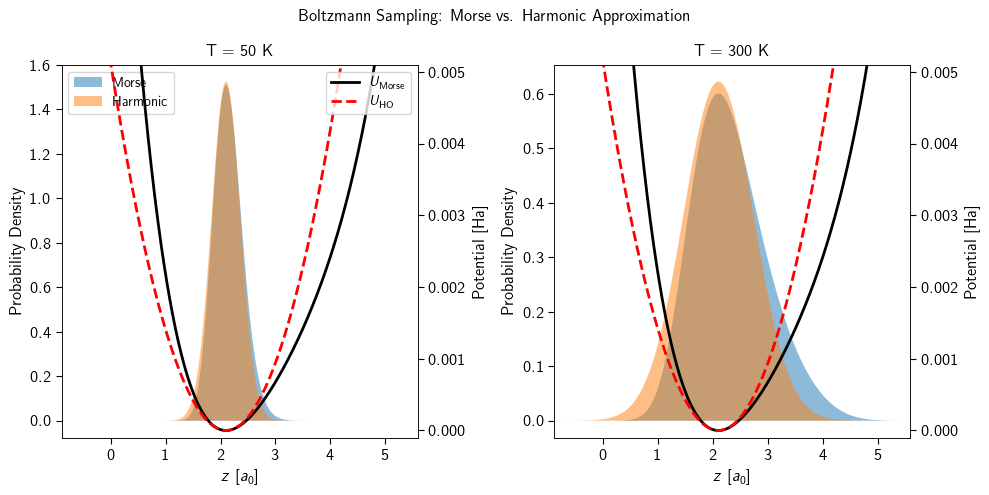

In [10]:
T1 = 50
T2 = 300
utils.plot_boltzmann_distribution_morse_vs_harmonic(T1,T2, span_z=(-3.0, 3.5), D=De, a=a, z0=z0, k=k)

## Classical anharmonic free energies


We compute the *classical* anharmonic free energy $ F_{\text{ca}} $ by thermodynamic integration,
$$
F_{\text{ca}} = F_{\text{ch}} + \int_0^1 \left\langle U_{\text{a}} - {U}_{\text{h}} \right\rangle_\lambda \, d\lambda,
$$
where $F_{\text{ch}}$ is the classical *harmonic* free energy computed above, $U_{\text{h}}(\mathbf{q})$ is the corresponding harmonic potential, and 
$U_{\text{a}}(\mathbf{q})$ is the full anharmonic potential. Recall from before that $\langle \cdots \rangle_{\lambda}$ denote the thermal average for the
"mixed" potential $\lambda U_{\text{a}}(\mathbf{q}) + (1-\lambda) U_{\text{h}}(\mathbf{q})$. 

Enter the classical TI directory `cd classical_ti` and prepare the inputs the define the reference harmonic potential

```bash
# link the hessian matrix
ln -s ../harmonic_approximation/simulation.phonons.hess hessian.data 
# store the equilibrium configuration
awk '{print $2, $3, $4}' ../geometry_optimization/simulation.pos_0.xyz | tail -1 > ref.data
# print the equilibrium energy
awk '{print $2}' ../harmonic_approximation/simulation.out | tail -1
```
Now open `input.xml`, and modify the following lines to define the mixed potential for thermodynamic integration:

```xml
<!-- Harmonic PES -->
<ffdebye name='harmonic'>
    <hessian shape='(3,3)' mode='file'> ... </hessian>          <!-- Path to the hessian matrix file -->
    <x_reference mode='file'> ... </x_reference>                <!-- Path to the equilibrium configuration -->
    <v_reference> ... </v_reference>                            <!-- value of the equilibrium -->
</ffdebye>
```

```xml
<!-- Anharmonic PES -->
<ffsocket name='anharmonic' mode='unix'>
    <address> f0 </address>
    <latency> 1e-3 </latency>
</ffsocket>
```

Lastly, link to the `RESTART` file from the geometry optimization, which we will use to initialize the coordinates at the start of our MD simulation.

```bash
ln -s ../geometry_optimization/RESTART geop-RESTART
```


By executing `./prepare_directories.sh` you will create a set of directories for the selected values of $ \lambda $. Here we use:

$$
\lambda \in \{ 0.0, 0.2, 0.4, 0.6, 0.8, 1.0 \}
$$


The script then will copy the input files from the parent directory into the new $ \lambda$ subfolders and specify the linear combination of harmonic and anharmonic forces in each `input.xml`:

```xml
<forces>
   <force forcefield='harmonic' weight='...'> </force>     <!-- 1 - lambda -->
   <force forcefield='anharmonic' weight='...'> </force>    <!-- lambda -->
</forces>
```


### Running the TI Simulations

The thermodynamic integration (TI) simulations are run at multiple values of $ \lambda $, each in its own subdirectory (e.g., `0.0/`, `0.2/`, …).

To launch all simulations at once, simply run:

```bash
./run_classical_ti.sh
```

This script first starts all i-PI server instances (one per $ \lambda $):

```bash
for x in ?.?/; do
  cd ${x}
  i-pi input.xml > log.i-pi &
  cd ..
done
```

Then, the corresponding drivers are launched with matching socket IDs (e.g., `f0`, `f2`, …):

```bash
for x in {0..10..2}; do
  i-pi-py_driver -u -a f${x} -m MorseHarmonic -o 0.2,0.75,1.11,1.0 &
done
```

Each driver connects to its respective i-PI instance to run the simulation at a specific $ \lambda $ value.


### Analyzing the free-energy difference

Once all simulations are finished, we read the potential energy components from each `pots` file and numerically integrate:
$$
\Delta F = \int_0^1 \left\langle U_{\text{a}} - {U}_{\text{h}} \right\rangle_\lambda \, d\lambda
$$
The integrand is plotted below.

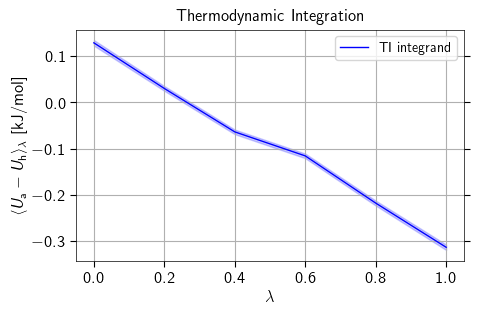

In [15]:
l_list = np.arange(0,11,2)/10
dir_list = [f"{l:.1f}" for l in l_list]
base_path = Path(".").joinpath('classical_ti') # Change to Path('outputs') to load precomputed results
filename = 'simulation.pots'
du_list, duerr_list = utils.TI_integrand(dir_list, base_path, filename, skip=100)

The integral gives the **anharmonic correction** to the classical free energy. 

In [16]:
# Integrate the energy difference using trapezoidal rule
dF_ch2ca = trapezoid(x=l_list, y=du_list)
# The corresponding error can be computed as
dF_ch2ca_err = np.sqrt(trapezoid(x=l_list, y=duerr_list**2))
# Compute the classical anharmonic free energy by adding the free energy difference to the harmonic free energy
T = 300.0 # Kelvin
F_ch = classical_harmonic_free_energy(Ws[-1], T)
print("Classical harmonic free energy:")
utils.print_energy(F_ch)
print("Anharmonic correction:")
utils.print_energy(dF_ch2ca, error=dF_ch2ca_err)
print("Classical free energy:")
F_ca = F_ch + dF_ch2ca
utils.print_energy(F_ca, error=dF_ch2ca_err)

Classical harmonic free energy:
   0.159 [mHa]
   4.31 [meV]
   0.416 [kJ/mol]

Anharmonic correction:
   -0.035 ± 0.002 [mHa]
   -0.95 ± 0.06 [meV]
   -0.092 ± 0.005 [kJ/mol]

Classical free energy:
   0.124 ± 0.002 [mHa]
   3.36 ± 0.06 [meV]
   0.325 ± 0.005 [kJ/mol]



## Quantum anharmonic free energies

### Mass thermodynamic integration

Mass thermodynamic integration (MTI) computes the quantum correction to the free energy using **PIMD**, 
by scaling the nuclear masses from the (infinitely heavy) classical limit to their "real-life" values [[2](https://doi.org/10.1063/1.2768930), [3](https://doi.org/10.1063/1.4772676)]. To this end, we introduce a mass-scaling parameter
$
g = \sqrt{\frac{m_0}{\mu}},
$
where
- $m_0 = $ is the physical mass of the system, and  
- $\mu$ is the fictitious mass used at each TI quadrature point.

Because the interpolation performed by MTI only affects the kinetic energy, and not the potential, the free-energy difference between the classical limit ($g \to 0$) and the quantum system ($g = 1$) now has the following form [[3](https://doi.org/10.1063/1.4772676), [4](https://doi.org/10.1021/acs.jpclett.6b00777)]:

$$
\Delta F^{c \to q} = 2 \int_0^1 \frac{\langle K(g) \rangle - \langle K \rangle^c}{g} \, dg
$$
where $\langle K(g) \rangle$ is the **quantum** kinetic energy (computed using the centroid-virial estimator) at mass $\mu = m_0/g^2$, and
$$
\langle K \rangle^c = \frac{f}{2}k_B T
$$
is the **classical** kinetic energy ($f$ is the number of degrees of freedom = dimensions $\times$ number of particles). Note that we do not evaluate the infinite-mass limit ($g = 0$) numerically, using the analytical result
$$
\lim_{g \to 0} \frac{\langle K(g) \rangle - \langle K \rangle^c}{g} = 0.
$$

### Input files

Navigate to the `mass_ti` directory and open `input.xml`. As we change $g$, the mass is modified:
```xml
    <masses mode="manual"> [ @MASS ] </masses> <!-- set to 1837.4 / g^2 -->
```
Scaling the mass by $g^{-2}$ affects the timescale on which our system (specifically, the ring-polymer centroids) moves, scaling it by $g^{-1}$. In our case, for unscaled masses, $\Delta t = 1.0~\mathrm{fs}$ is a good choice:
```xml
    <timestep units='femtosecond'> @DT </timestep> <!-- set to 1.0 / g -->
```
The [PILE-L](https://docs.ipi-code.org/input-tags.html#thermostat) thermostat constant $\tau$ is scaled in the same way:
```xml
    <tau units='femtosecond'> @TAU </tau> <!-- set to 20.0 / g -->
```
Finally, the number of beads needed for convergence scales as $g$. You can see the values we have chosen for our calculations in `prepare_directories.sh`:
```bash
    lambdas=(0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0)
    nbeads=(4 4 8 8 12 12 12 16 16 16) 
```
Executing `./prepare_directories.sh` set up the input files for running PIMD simulations for different scaled masses.

### Integrating the Free Energy

We are not going to run any simulation of mass TI in this tutorial. Due to time constrains we will only analyze the data in the directory `outputs/mass_ti` to 
extract the values of $\langle K(g) \rangle / g$
and numerically integrate to obtain the **quantum correction** to the classical free energy.

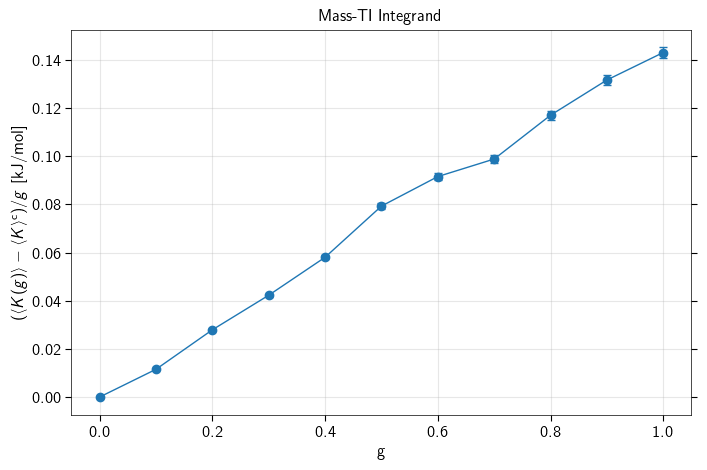

In [17]:
T = 300.0 #Kelvin
tutorialpath = Path("outputs")
path = tutorialpath.joinpath('mass_ti')
dir_list = [f"{i*0.1:.1f}" for i in range(1,11)]
du_list, sigma_list, g_list = utils.mass_TI_integrand(path, T, dir_list, skip=100)

In [18]:
T = 300.0
# Integrate and propagate error
dF_ca2qa = 2 * trapezoid(y=du_list, x=g_list)
dF_ca2qa_err =  np.sqrt( 4*trapezoid(y=sigma_list**2, x=g_list) )
# Print the free energy difference from the Mass‐TI
print("Mass TI free energy difference:")
utils.print_energy(dF_ca2qa, error=dF_ca2qa_err)
print("Mass TI total free energy:")
F_qa = F_ca + dF_ca2qa
F_qa_err = np.sqrt(dF_ch2ca_err**2 + dF_ca2qa_err**2)
utils.print_energy(F_qa, error=F_qa_err)

Mass TI free energy difference:
   0.056 ± 0.001 [mHa]
   1.51 ± 0.03 [meV]
   0.146 ± 0.003 [kJ/mol]

Mass TI total free energy:
   0.179 ± 0.002 [mHa]
   4.88 ± 0.06 [meV]
   0.470 ± 0.006 [kJ/mol]



### PIMD TI

The alternative approach to computing free energies is to use a **quantum** harmonic reference and then perform a thermodynamics integration from the harmonic to the full anharmonic potential with PIMD. The procedure is exactly analogous to classical TI, the only difference being that the classical particles are replaced by ring polymers. We will not look at this in detail, but feel free to examine `outputs/pimd_ti`.

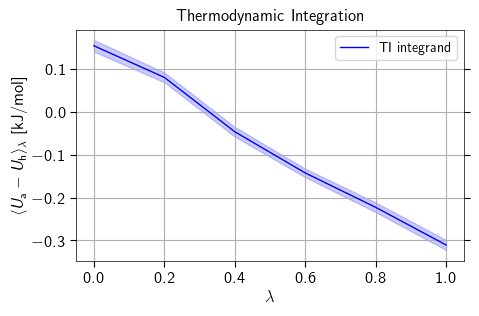

In [19]:
l_list = np.arange(0,11,2)/10
dir_list = [f"{l:.1f}" for l in l_list]
base_path = Path("outputs").joinpath('pimd_ti') 
filename = 'simulation.pots'
du_list, duerr_list = utils.TI_integrand(dir_list, base_path, filename, skip=100)

In [20]:
# Integrate the energy difference using trapezoidal rule
dF_qh2qa = trapezoid(x=l_list, y=du_list)
# The corresponding error can be computed as
dF_qh2qa_err = np.sqrt(trapezoid(x=l_list, y=duerr_list**2))
# Compute the quantum anharmonic free energy by adding the free energy difference to the harmonic free energy
T = 300.0 # Kelvin
F_qh = quantum_harmonic_free_energy(Ws[-1], T)
print("Quantum harmonic free energy:")
utils.print_energy(F_qh)
print("Anharmonic correction:")
utils.print_energy(dF_qh2qa, error=dF_qh2qa_err)
print("Quantum free energy:")
F_qa = F_qh + dF_qh2qa
utils.print_energy(F_qa, error=dF_qh2qa_err)

Quantum harmonic free energy:
   0.213 [mHa]
   5.80 [meV]
   0.560 [kJ/mol]

Anharmonic correction:
   -0.031 ± 0.004 [mHa]
   -0.85 ± 0.12 [meV]
   -0.082 ± 0.011 [kJ/mol]

Quantum free energy:
   0.182 ± 0.004 [mHa]
   4.95 ± 0.12 [meV]
   0.478 ± 0.011 [kJ/mol]



## Final result

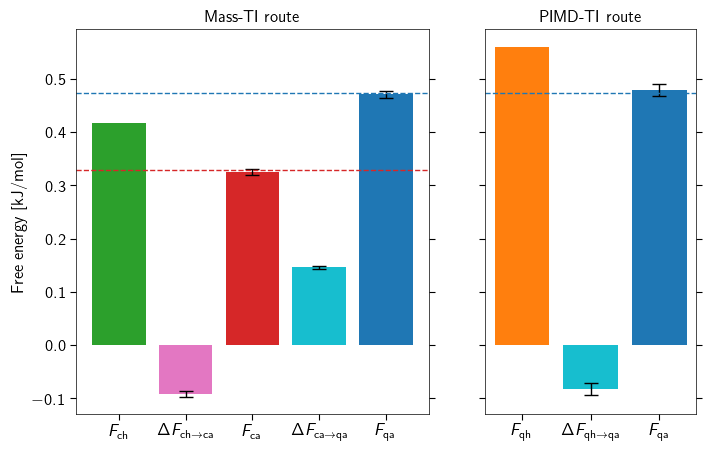

In [21]:
utils.plot_free_energy_decomposition(
    F_ch, 
    dF_ch2ca, dF_ch2ca_err, 
    dF_ca2qa, dF_ca2qa_err, 
    F_qh, 
    dF_qh2qa, dF_qh2qa_err, 
    1.249e-4, 1.806e-4)